In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0.0    39402
1.0    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

# Split

In [3]:
train_df, test_df = split_train_test_data_v2(data)

# Extraction des séquences et normalisation

In [4]:
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_column, inplace=True)
/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_column, inplace=True)


In [5]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 35), (24514,), (6132, 6, 35), (6132,))

# Modèle

In [6]:
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.

    Args:
    - X_train: Séquences d'entraînement (padded).
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation (padded).
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle LSTM entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(64),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


# Entrainement 

In [7]:
from keras.regularizers import l2

In [8]:
input_shape = (6, 35)  # time steps, features
model_1, history_1 = build_and_train_lstm_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)

Epoch 1/300


/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5711 - loss: 0.6823 - val_accuracy: 0.5698 - val_loss: 0.6707
Epoch 2/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6277 - loss: 0.6425 - val_accuracy: 0.7105 - val_loss: 0.5689
Epoch 3/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7195 - loss: 0.5568 - val_accuracy: 0.7290 - val_loss: 0.5488
Epoch 4/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7327 - loss: 0.5382 - val_accuracy: 0.7241 - val_loss: 0.5499
Epoch 5/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7427 - loss: 0.5263 - val_accuracy: 0.7355 - val_loss: 0.5410
Epoch 6/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7445 - loss: 0.5242 - val_accuracy: 0.7394 - val_loss: 0.5494
Epoch 7/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7419 - loss: 0.5253 - val_accuracy: 0.7394 - val_loss: 0.5443
Epoch 8/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7465 - loss: 0.5199 - val_accuracy

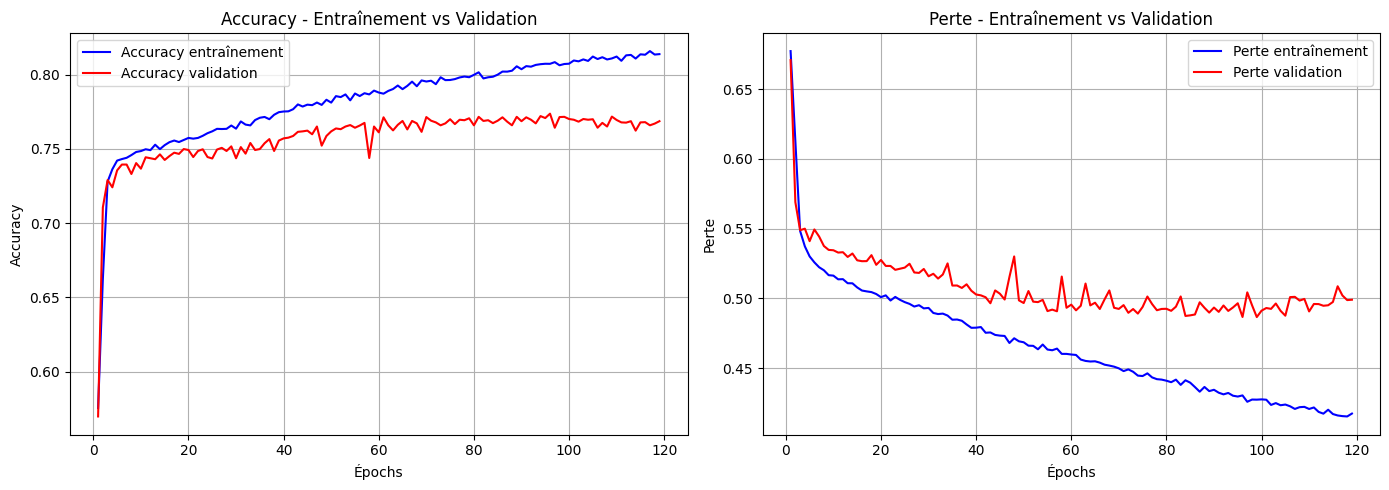

In [9]:
plot_training_history(history_1)

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7715
Precision: 0.7229
Recall: 0.7764
F1-Score: 0.7487
AUROC: 0.8430


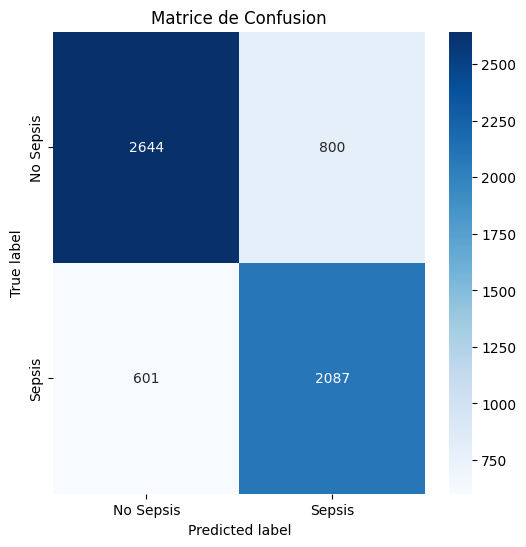

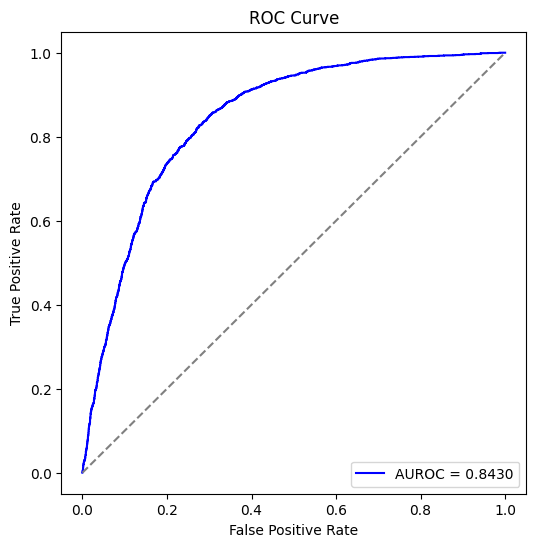

In [10]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_1, normalize_sequences_test, labels_test)